# nvisia Face Swap Demo!

Swap some faces! Uses OpenCV and Dlib. Runs best on GPU.

In [1]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

## Face to swap

In [2]:
img_face = cv2.imread("data/2.jpg")

## Body to swap onto

In [3]:
img_body = cv2.imread("data/10.png")

In [4]:
# function to get facial landmarks
landmarks_data_file = "data/shape_predictor_68_face_landmarks.dat"

def get_landmarks(landmarks, landmarks_points):
    for point_index in range(68):
        x = landmarks.part(point_index).x
        y = landmarks.part(point_index).y
        landmarks_points.append((x, y))

In [5]:
# utility function to get indices
def get_index(arr):
    index = 0
    if arr[0].any():
        index = arr[0][0]
        
    return index

In [6]:
img_face_gray = cv2.cvtColor(img_face, cv2.COLOR_BGR2GRAY)
img_body_gray = cv2.cvtColor(img_body, cv2.COLOR_BGR2GRAY)

In [7]:
height, width = img_face_gray.shape
mask = np.zeros((height, width), np.uint8)

height, width, channels = img_body.shape

In [8]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(landmarks_data_file)

In [9]:
# Face 1
faces = detector(img_face_gray)

if len(faces) < 1:
    print("No faces detected for source")
    
rect = faces[0]
landmarks = predictor(img_face_gray, rect)
landmarks_points = []

get_landmarks(landmarks, landmarks_points)
points = np.array(landmarks_points, np.int32)

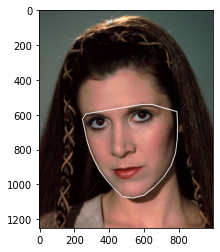

In [10]:
convexhull = cv2.convexHull(points)

# Visualize
face_image_copy = img_face.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face_image_copy, [convexhull], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))
face_image_1 = cv2.bitwise_and(img_face, img_face, mask=mask)

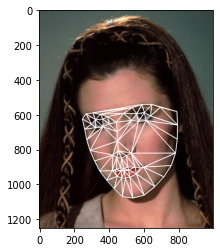

In [11]:
rect = cv2.boundingRect(convexhull)
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points)
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

triangle_indices = []
face_image_copy = img_face.copy()

for triangle in triangles:
    point1 = (triangle[0], triangle[1])
    point2 = (triangle[2], triangle[3])
    point3 = (triangle[4], triangle[5])
    
    cv2.line(face_image_copy, point1, point2, (255, 255, 255), 3, 0)
    cv2.line(face_image_copy, point2, point3, (255, 255, 255), 3, 0)
    cv2.line(face_image_copy, point3, point1, (255, 255, 255), 3, 0)
    
    index_point1 = np.where((points == point1).all(axis=1))
    index_point1 = get_index(index_point1)
    index_point2 = np.where((points == point2).all(axis=1))
    index_point2 = get_index(index_point2)
    index_point3 = np.where((points == point3).all(axis=1))
    index_point3 = get_index(index_point3)
    
    # Validate triangle
    if index_point1 is not None and index_point2 is not None and index_point3 is not None:
        vertices = [index_point1, index_point2, index_point3]
        triangle_indices.append(vertices)
        
# Visualize
plt.imshow(cv2.cvtColor(face_image_copy, cv2.COLOR_BGR2RGB))

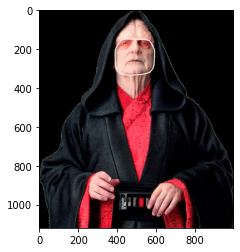

In [12]:
# Face 2
faces2 = detector(img_body_gray)

if len(faces2) < 1:
    print("No faces detected for target")

rect2 = faces2[0]

landmarks2 = predictor(img_body_gray, rect2)
landmarks_points2 = []

get_landmarks(landmarks2, landmarks_points2)

points2 = np.array(landmarks_points2, np.int32)
convexhull2 = cv2.convexHull(points2)

# Visualize
body_image_copy = img_body.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(body_image_copy, [convexhull2], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

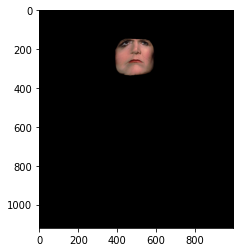

In [13]:
# Grab new face area and warp it to match implant face
lines_space_new_face = np.zeros((height, width, channels), np.uint8)
body_new_face = np.zeros((height, width, channels), np.uint8)

height, width = img_face_gray.shape
lines_space_mask = np.zeros((height, width), np.uint8)

for triangle in triangle_indices:
    point1 = landmarks_points[triangle[0]]
    point2 = landmarks_points[triangle[1]]
    point3 = landmarks_points[triangle[2]]
    
    (x, y, width, height) = cv2.boundingRect(np.array([point1, point2, point3], np.int32))
    cropped_triangle = img_face[y: y+height, x: x+width]
    cropped_mask = np.zeros((height, width), np.uint8)
    
    points = np.array([[point1[0]-x, point1[1]-y], [point2[0]-x, point2[1]-y], [point3[0]-x, point3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, points, 255)
    
    cv2.line(lines_space_mask, point1, point2, 255)
    cv2.line(lines_space_mask, point2, point3, 255)
    cv2.line(lines_space_mask, point1, point3, 255)
    
    lines_space = cv2.bitwise_and(img_face, img_face, mask=lines_space_mask)
    
    point1 = landmarks_points2[triangle[0]]
    point2 = landmarks_points2[triangle[1]]
    point3 = landmarks_points2[triangle[2]]
    
    (x, y, width, height) = cv2.boundingRect(np.array([point1, point2, point3], np.int32))
    cropped_mask2 = np.zeros((height, width), np.uint8)
    
    points2 = np.array([[point1[0]-x, point1[1]-y], [point2[0]-x, point2[1]-y], [point3[0]-x, point3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)
    
    # affine warp
    points = np.float32(points)
    points2 = np.float32(points2)
    
    # M is a matrix
    M = cv2.getAffineTransform(points, points2)
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (width, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)
    
    body_new_face_rect_area = body_new_face[y: y+height, x: x+width]
    body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    
    masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])
    
    body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
    body_new_face[y: y+height, x: x+width] = body_new_face_rect_area
    
# Visualize
plt.imshow(cv2.cvtColor(body_new_face, cv2.COLOR_BGR2RGB))

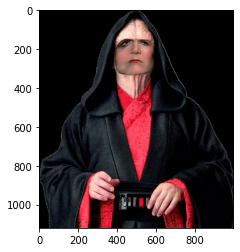

In [14]:
# Face swap!
body_face_mask = np.zeros_like(img_body_gray)
body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
body_face_mask = cv2.bitwise_not(body_head_mask)

body_maskless = cv2.bitwise_and(img_body, img_body, mask=body_face_mask)
result = cv2.add(body_maskless, body_new_face)

# Visualize
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

True

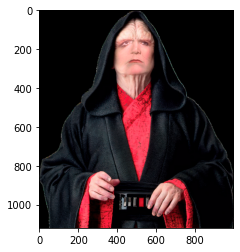

In [15]:
# Seamless clone
(x, y, width, height) = cv2.boundingRect(convexhull2)
center_face2 = (int((x+x+width)/2), int((y+y+height)/2))

seamlessclone = cv2.seamlessClone(result, img_body, body_head_mask, center_face2, cv2.NORMAL_CLONE)

# Visualize
plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB))

# Save
cv2.imwrite("./result.png", seamlessclone)